In [204]:
from matplotlib import pyplot as plt
from systemclass import SNAIL,SNAIL_sweep,Cavity, SNAILC, SNAILC_sweep, SNAILCC, SNAILCC_sweep
import numpy as np
from joblib import Parallel, delayed
import qutip as qt
from qutip import propagator,floquet_modes,Qobj,Options,basis
from scipy.optimize import fsolve
import numpy as np
def state_index(index,dim):
    m,n,k = index
    M,N,K = dim
    return m*(N*K)+n*K+k
def sort_eigenpairs(eigenvalues, eigenvectors):
    n = eigenvectors.shape[0]
    sorted_indices = []

    for i in range(n):
        max_abs_vals = np.abs(eigenvectors[i, :])
        max_index = np.argmax(max_abs_vals)
        while max_index in sorted_indices:
            max_abs_vals[max_index] = -np.inf
            max_index = np.argmax(max_abs_vals)
        sorted_indices.append(max_index)

    sorted_eigenvalues = eigenvalues[sorted_indices]
    sorted_eigenvectors = eigenvectors[:, sorted_indices]

    return sorted_eigenvalues, sorted_eigenvectors
    
    return sorted_eigenvalues, sorted_eigenvectors
# def integral_of_pulse(max_amplitude, duration, t0,t1, target_area):
#     duration = t1+t0
#     func = gaussian_pulse(t0,t1, max_amplitude)
#     t_values = np.linspace(0,duration,10000)
#     func_values = np.array([np.array(func(t)) for t in t_values])
#     func_values = func_values.reshape(10000)
#     current_area = np.trapz(func_values, t_values)
    
#     return current_area - target_area  # we want this to be zero

# def find_max_amplitude(duration,t0,t1, target_area):

#     # Initial guess for max_amplitude
#     initial_guess = 1.0
#     # Use fsolve to find the root, i.e., when integral_of_pulse returns 0
#     max_amplitude, = fsolve(integral_of_pulse, initial_guess, args=(duration,t0,t1, target_area))
#     return max_amplitude
def gaussian_pulse(t0,t1,amplitude):
    ramp_time = 50
    # Standard deviation for the Gaussian pulse
    sigma = ramp_time / 3 # Assuming the pulse mostly lies within +/- 3 sigma
    
    
    # Generate the Gaussian pulse
    def time_dependent_function(t):
        if t <= t0:
            pulse = 0
        elif t <= t1:
            t = t-t0
            offset = amplitude * np.exp(-((0 - ramp_time)**2) / (2 * sigma**2))
            if t<ramp_time:
                pulse =  max_amplitude * np.exp(-0.5 * ((t - ramp_time) / sigma) ** 2)-offset
            elif t< t1-t0-ramp_time:
                pulse = amplitude - offset
            else:
                pulse = amplitude * np.exp(-((t - (t1-t0-ramp_time))**2) / (2 * sigma**2)) - offset
        else:
            pulse =  0
        if type(pulse) == np.ndarray:
            pulse = pulse[0]
        return pulse
    return time_dependent_function
def gaussian_ramp(t0,t1, amplitude):
    """
    Creates a time-dependent function using a Gaussian function that starts near zero,
    peaks at 'amplitude' at time 't0', and remains constant at 'amplitude' for t > t0.

    Args:
    t0 (float): The time at which the function peaks at the amplitude.
    amplitude (float): The maximum amplitude of the Gaussian peak.

    Returns:
    function: A function of time 't' that implements the desired behavior.
    """
    # Define the standard deviation such that the peak is sharp at t0
    sigma = t0 / 3  # Adjust sigma to make the function start close to zero at t=0
    
    offset = amplitude * np.exp(-((0 - t0)**2) / (2 * sigma**2))
    
    # Define the function using a closure to encapsulate the parameters
    def time_dependent_function(t):
        if t <= t0:
            # Gaussian function for ramp up
            return amplitude * np.exp(-((t - t0)**2) / (2 * sigma**2)) - offset
        elif t <= t1:
            # Constant amplitude between t0 and t1
            return amplitude - offset
        else:
            # Symmetric Gaussian function for ramp down
            return amplitude * np.exp(-((t - t1)**2) / (2 * sigma**2)) - offset

    return time_dependent_function

def energy_diff(t0,duration,t1,amplitude,omega):
    flux =0.432
    #snail parameters
    EJ = 100*2*np.pi
    EC = 0.177*2*np.pi
    beta = 0.12
    ng = 0
    ncut = 300
    N = 3
    dims = 14
    snail = SNAIL(EJ,EC,beta,ng,ncut,flux,N,dims)
    Hs,charge_op = snail.spectrum_charge()


    #cavity1 parameters
    omega_c1 = 4.5*2*np.pi
    g_int1 = 0.15/2*(6-omega_c1/2/np.pi)*2*np.pi
    dimc1 = 5
    cavity1 = Cavity(omega_c1,g_int1,dimc1)

    #cavity1 parameters
    omega_c2 =  8.5*2*np.pi
    g_int2 = 0.15/2*(6-omega_c2/2/np.pi)*2*np.pi
    dimc2 = 5
    cavity2 = Cavity(omega_c2,g_int2,dimc2)

    Hc1, Vc1 = cavity1.hamiltonian()
    Hc2, Vc2 = cavity2.hamiltonian()

    Ic1 = np.identity(dimc1)
    Ic2 = np.identity(dimc2)
    Is = np.identity(dims)

    Hs = np.kron(np.kron(Hs,Ic1),Ic2)
    Hc1 = np.kron(np.kron(Is,Hc1),Ic2)
    Hc2 = np.kron(np.kron(Is,Ic1),Hc2)

    H_int1 = cavity1.g_int * np.kron(np.kron(charge_op,Vc1),Ic2) * 2 * ((2 * snail.EC / snail.EJ) ** 0.25)
    H_int2 = cavity2.g_int * np.kron(np.kron(charge_op,Ic1),Vc2) * 2 * ((2 * snail.EC / snail.EJ) ** 0.25)

    H = Hs + Hc1 + Hc2 + H_int1 + H_int2
    Hc  =  np.kron(np.kron(charge_op,Ic1),Ic2)
    energy0,U = np.linalg.eigh(H)
    energy0,U = sort_eigenpairs(energy0, U)
    Ud = U.transpose().conjugate()
    H = Ud@H@U
    Hc = Ud@Hc@U

    index1 = np.argmin(np.abs(energy0 - omega_c1 * np.ones(len(energy0))))
    index2 = np.argmin(np.abs(energy0 - omega_c2 * np.ones(len(energy0))))

    total_dim = dims*dimc1*dimc2
    H0 = Qobj(H)
    Hc = Qobj(Hc)
    psi0 = qt.basis(total_dim, index1)
    Iss = qt.qeye(dims)
    s0 = qt.basis(dims, 0)*(qt.basis(dims, 0).dag())
    cavity0 = qt.basis(dimc1, 0)*(qt.basis(dimc1, 0).dag())
    cavity1 = qt.basis(dimc1, 1)*(qt.basis(dimc1, 1).dag())
    cavity2 = qt.basis(dimc1, 2)*(qt.basis(dimc1, 2).dag())
    PP1 = qt.Qobj(np.array(qt.tensor(Iss, cavity0, cavity1).full()))
    PP2 = qt.Qobj(np.array(qt.tensor(Iss, cavity1, cavity0).full()))
    omega1 =  5.8* 2 * np.pi
#     amplitude = find_max_amplitude(initial_duration,t0,t1, target_area=6700)
    func = gaussian_pulse(t0,t1, amplitude )
    func1 = gaussian_ramp(t0 ,t1,0.003 * 2 * np.pi)
#     omega = 4.0104625*2*np.pi
    
    args = {'w': omega,'w1':omega1}
    tlist = np.linspace(0, duration, 100000)  # Cover ten periods
    H = [H0, [Hc, lambda t, args: func(t)*np.cos(args['w']*t)],[Hc, lambda t, args: func1(t)*np.cos(args['w1']*t)]]

    result = qt.sesolve(H, psi0, tlist, args=args)
    exp_P1 = np.array([qt.expect(PP1, state) for state in result.states])
    exp_P2 = np.array([qt.expect(PP2, state) for state in result.states])
    return exp_P1,exp_P2

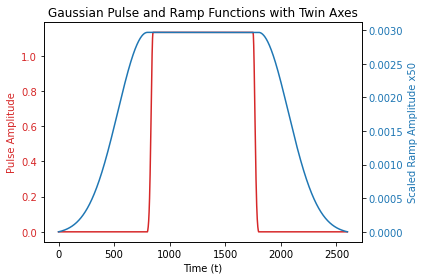

In [205]:

# Parameters for the Gaussian functions
t0 = 800
t1 = t0+1000
duration = t1+t0
max_amplitude =1.1459158455310345

# Create the Gaussian pulse and ramp functions
pulse_function = gaussian_pulse(t0, t1, max_amplitude)
ramp_function = gaussian_ramp(t0, t1, 0.003 * 2 * np.pi)

# Generate the time values and function values
t_values = np.arange(duration)
pulse_values = np.array([np.array(pulse_function(t)) for t in t_values])
pulse_values.reshape(duration)
ramp_values = [ramp_function(t) for t in t_values]


# Create a figure and a set of subplots
fig, ax1 = plt.subplots()

# Plot the first data set on the primary y-axis
color = 'tab:red'
ax1.set_xlabel('Time (t)')
ax1.set_ylabel('Pulse Amplitude', color=color)
ax1.plot(t_values, pulse_values, color=color)
ax1.tick_params(axis='y', labelcolor=color)

# Create a second y-axis for the second data set
ax2 = ax1.twinx()  
color = 'tab:blue'
ax2.set_ylabel('Scaled Ramp Amplitude x50', color=color)  # we already handled the x-label with ax1
ax2.plot(t_values, np.array(ramp_values)/2/np.pi , color=color)
ax2.tick_params(axis='y', labelcolor=color)

# Add title and grid
plt.title('Gaussian Pulse and Ramp Functions with Twin Axes')
fig.tight_layout()  # To ensure there's no overlap
plt.show()

In [206]:
sum(pulse_values)*2*np.pi

6699.997625504709

In [207]:
t0 = 800
t1s = np.linspace(t0+1000+0, t0+1000+30, 10)  # 11 points for 10 intervals

omega_values = np.linspace(4.01046,4.010475,5) * 2 * np.pi
# Define the range for omega values, scaling by 2*pi
max_amplitude = 1.1185443935505557*2*np.pi
# Use joblib to parallelize the calculation over both durations and omega values
results = Parallel(n_jobs=-1)(
    delayed(energy_diff)(t0,t1+t0, t1,max_amplitude, omega)
    for t1 in t1s
    for omega in omega_values 
)


In [208]:
# t0 = 800
# t1s = np.linspace(t0+500+40, t0+500+50, 10)  # 11 points for 10 intervals

# omega_values = np.linspace(4.00982,4.00984,5) * 2 * np.pi
# # Define the range for omega values, scaling by 2*pi
# max_amplitude = 4.083976633689181*2*np.pi
# # Use joblib to parallelize the calculation over both durations and omega values
# results = Parallel(n_jobs=-1)(
#     delayed(energy_diff)(t0,t1+t0, t1,max_amplitude, omega)
#     for t1 in t1s
#     for omega in omega_values 
# )


In [209]:
results = np.array(results)

In [211]:
results[:,0,-1].reshape(10,5)

array([[0.99692995, 0.99710424, 0.99717981, 0.99715664, 0.99703474],
       [0.9971743 , 0.99735012, 0.99742633, 0.99740294, 0.99727993],
       [0.99735823, 0.99753559, 0.99761248, 0.99758888, 0.99746479],
       [0.99748289, 0.99766182, 0.99773941, 0.99771563, 0.99759048],
       [0.99754941, 0.99772994, 0.99780824, 0.9977843 , 0.99765811],
       [0.9975587 , 0.99774084, 0.99781989, 0.99779581, 0.99766861],
       [0.99751149, 0.99769528, 0.99777508, 0.99775088, 0.99762268],
       [0.99740821, 0.99759365, 0.99767423, 0.99764991, 0.99752073],
       [0.99724898, 0.99743609, 0.99751744, 0.99749302, 0.99736284],
       [0.99703363, 0.9972224 , 0.99730453, 0.99728001, 0.99714884]])

In [132]:
omega_values/2/np.pi

array([4.00982 , 4.009825, 4.00983 , 4.009835, 4.00984 ])

In [133]:
t1s

array([1340.        , 1341.11111111, 1342.22222222, 1343.33333333,
       1344.44444444, 1345.55555556, 1346.66666667, 1347.77777778,
       1348.88888889, 1350.        ])

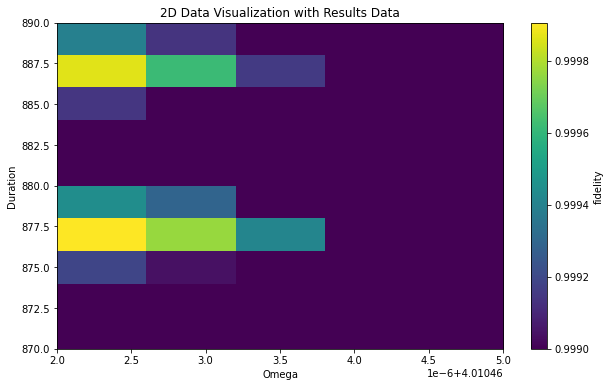

In [44]:
import numpy as np
import matplotlib.pyplot as plt

# Assuming 'results' array as specified
data_slice = results[:, 0, -1].reshape(5,10)
omega_values = np.linspace(4.010462,4.010465,5) * 2 * np.pi
omega_values = omega_values/2/np.pi

# Creating the 2D plot using imshow
plt.figure(figsize=(10, 6))
# Transposing data_slice so that the x-axis (omega) and y-axis (duration) match correctly
im = plt.imshow(data_slice.T, aspect='auto', extent=[omega_values.min(), omega_values.max(), t1s.min(), t1s.max()], origin='lower', cmap='viridis',vmin = 0.999)
plt.colorbar(im, label='fidelity')  # Add a colorbar to a plot
plt.xlabel('Omega')
plt.ylabel('Duration')
plt.title('2D Data Visualization with Results Data')
plt.show()

In [226]:
t0 = 800
t1 = t0+1000-5
omega = 4.0104675*2*np.pi
duration = t0+t1
# Define the range for omega values, scaling by 2*pi
amplitude = 1.1185443935505557*2*np.pi

flux =0.432
#snail parameters
EJ = 100*2*np.pi
EC = 0.177*2*np.pi
beta = 0.12
ng = 0
ncut = 300
N = 3
dims = 12
snail = SNAIL(EJ,EC,beta,ng,ncut,flux,N,dims)
Hs,charge_op = snail.spectrum_charge()


#cavity1 parameters
omega_c1 = 4.5*2*np.pi
g_int1 = 0.15/2*(6-omega_c1/2/np.pi)*2*np.pi
dimc1 = 4
cavity1 = Cavity(omega_c1,g_int1,dimc1)

#cavity1 parameters
omega_c2 =  8.5*2*np.pi
g_int2 = 0.15/2*(6-omega_c2/2/np.pi)*2*np.pi
dimc2 = 4
cavity2 = Cavity(omega_c2,g_int2,dimc2)

Hc1, Vc1 = cavity1.hamiltonian()
Hc2, Vc2 = cavity2.hamiltonian()

Ic1 = np.identity(dimc1)
Ic2 = np.identity(dimc2)
Is = np.identity(dims)

Hs = np.kron(np.kron(Hs,Ic1),Ic2)
Hc1 = np.kron(np.kron(Is,Hc1),Ic2)
Hc2 = np.kron(np.kron(Is,Ic1),Hc2)

H_int1 = cavity1.g_int * np.kron(np.kron(charge_op,Vc1),Ic2) * 2 * ((2 * snail.EC / snail.EJ) ** 0.25)
H_int2 = cavity2.g_int * np.kron(np.kron(charge_op,Ic1),Vc2) * 2 * ((2 * snail.EC / snail.EJ) ** 0.25)

H = Hs + Hc1 + Hc2 + H_int1 + H_int2
Hc  =  np.kron(np.kron(charge_op,Ic1),Ic2)
energy0,U = np.linalg.eigh(H)
energy0,U = sort_eigenpairs(energy0, U)
Ud = U.transpose().conjugate()
H = Ud@H@U
Hc = Ud@Hc@U

index1 = np.argmin(np.abs(energy0 - omega_c1 * np.ones(len(energy0))))
index2 = np.argmin(np.abs(energy0 - omega_c2 * np.ones(len(energy0))))

total_dim = dims*dimc1*dimc2
H0 = Qobj(H)
Hc = Qobj(Hc)
psi0 = qt.basis(total_dim, index1)
Iss = qt.qeye(dims)
s0 = qt.basis(dims, 0)*(qt.basis(dims, 0).dag())
cavity0 = qt.basis(dimc1, 0)*(qt.basis(dimc1, 0).dag())
cavity1 = qt.basis(dimc1, 1)*(qt.basis(dimc1, 1).dag())
cavity2 = qt.basis(dimc1, 2)*(qt.basis(dimc1, 2).dag())
PP1 = qt.Qobj(np.array(qt.tensor(Iss, cavity0, cavity1).full()))
PP2 = qt.Qobj(np.array(qt.tensor(Iss, cavity1, cavity0).full()))
omega1 =  5.8* 2 * np.pi
#     amplitude = find_max_amplitude(initial_duration,t0,t1, target_area=6700)
func = gaussian_pulse(t0,t1, amplitude )
func1 = gaussian_ramp(t0 ,t1,0.003 * 2 * np.pi)
#     omega = 4.0104625*2*np.pi

args = {'w': omega,'w1':omega1}
tlist = np.linspace(0, duration, 100000)  # Cover ten periods
H = [H0, [Hc, lambda t, args: func(t)*np.cos(args['w']*t)],[Hc, lambda t, args: func1(t)*np.cos(args['w1']*t)]]

result = qt.sesolve(H, psi0, tlist, args=args)

In [227]:
result.states[-1]

Quantum object: dims=[[192], [1]], shape=(192, 1), type='ket', dtype=Dense
Qobj data =
[[-2.95683988e-05-1.85387432e-05j]
 [-5.96073520e-01-7.82875532e-01j]
 [ 3.21900899e-05+3.36680442e-05j]
 [-1.70249579e-10+1.74451566e-09j]
 [-1.75950558e-02+2.42499146e-02j]
 [ 4.42954313e-05+9.12754151e-06j]
 [-6.76140895e-10+5.59815584e-10j]
 [ 2.14573903e-11+1.28321438e-10j]
 [ 6.47850512e-06+6.21152503e-06j]
 [ 2.68018007e-08+5.92544772e-09j]
 [ 1.26970026e-09+8.02287769e-10j]
 [-8.43699084e-13+1.16711804e-12j]
 [ 8.55086640e-09+1.28937418e-08j]
 [-1.25486482e-09-1.18786504e-11j]
 [ 2.19230910e-11+1.95327688e-11j]
 [-7.67614384e-14-4.37903968e-13j]
 [-7.73760764e-06-5.03230558e-06j]
 [-1.55215452e-01+6.63568113e-02j]
 [-6.86658351e-07-4.95499853e-06j]
 [-2.66566635e-11-9.88933506e-12j]
 [ 4.86408727e-02+6.59712499e-03j]
 [-1.83948392e-06+9.16974826e-06j]
 [ 4.09267502e-10-1.50312500e-09j]
 [-1.25405633e-12-1.67658104e-12j]
 [ 2.24951624e-06-2.97214724e-06j]
 [-7.83363963e-10-1.39733640e-09j]
 [-

In [247]:
PP1 = qt.Qobj(np.array(qt.tensor(s0, cavity0, cavity1).full()))
PP2 = qt.Qobj(np.array(qt.tensor(s0, cavity1, cavity0).full()))
exp_P1 = np.array([qt.expect(PP1, state) for state in result.states])
exp_P2 = np.array([qt.expect(PP2, state) for state in result.states])

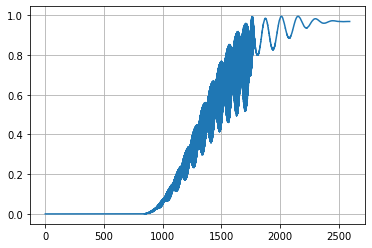

In [249]:
plt.plot(tlist,exp_P1)
plt.grid()

In [250]:
exp_P1

array([0.00000000e+00, 8.90861125e-26, 1.75181861e-25, ...,
       9.68197737e-01, 9.68197739e-01, 9.68197741e-01])

In [253]:
exp_P2

array([1.00000000e+00, 1.00000000e+00, 1.00000000e+00, ...,
       8.97644339e-04, 8.97644342e-04, 8.97644346e-04])